<a href="https://colab.research.google.com/github/AbhishekSinghKushwah7/Plant-Disease-Identification-via-Deep-Learning/blob/main/RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 2**

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/new_drive')

Mounted at /content/new_drive


In [3]:
train_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL/train"
val_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL/val"
test_dir = "/content/new_drive/MyDrive/Colab Notebooks/thermal images UL/test"

classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [4]:
def preprocess_function(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image

In [35]:
datagen = ImageDataGenerator(rescale=1.0/255,
                             preprocessing_function=preprocess_function)

IMAGE_SIZE = (224, 224) # Compatible with the input size the pre-trained model was trained on
BATCH_SIZE = 4

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 586 images belonging to 6 classes.
Found 317 images belonging to 6 classes.


In [48]:
def build_rcnn_model(input_shape=(224, 224, 3), num_classes=6):

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)


    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_rcnn_model()


In [49]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │     205,521,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,898,886 (785.44 MB)

 Trainable params: 205,898,886 (785.44 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, restore_best_weights=True) # min_delta was chosen 0.005 after multiple testing with different values

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 136ms/step - accuracy: 0.4143 - loss: 1.6192 - val_accuracy: 0.6877 - val_loss: 0.8495
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.6760 - loss: 0.8682 - val_accuracy: 0.8454 - val_loss: 0.5664
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.7682 - loss: 0.6777 - val_accuracy: 0.7981 - val_loss: 0.5695
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8158 - loss: 0.5031 - val_accuracy: 0.9022 - val_loss: 0.3163
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.8417 - loss: 0.3755 - val_accuracy: 0.8927 - val_loss: 0.3442
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.8796 - loss: 0.3736 - val_accuracy: 0.9180 - val_loss: 0.2376
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.9161 - loss: 0.2480 - val_accuracy: 0.9022 - val_loss: 0.2299
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - accuracy: 0.9083 - loss: 0.2432 

In [51]:
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,

    class_mode='categorical'
)

Found 222 images belonging to 6 classes.


In [52]:
# Step 5: Evaluate the Model
eval_results = model.evaluate(test_gen)
print(f"Test Accuracy: {eval_results[1] * 100:.2f}%")

 1/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.7500 - loss: 0.6480

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9585 - loss: 0.1193
Test Accuracy: 98.65%


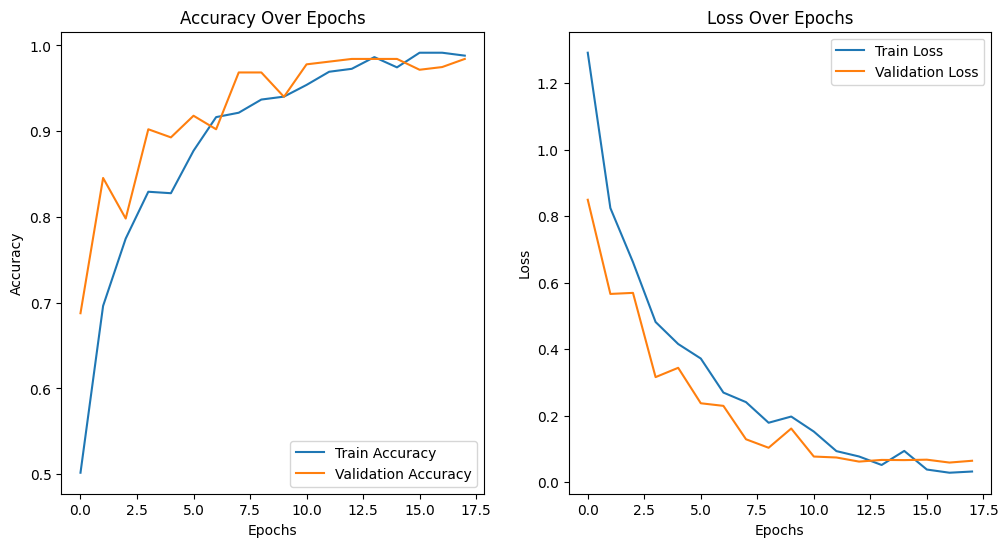

In [53]:
# Step 6: Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [54]:
# Save the model
model.save("RCNN.h5")
print("Model saved.")

Model saved.
